In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_SAVE_DATA = ROOT + "\\Spec2Vec\\data\\"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions

## Import unique-inchi subset

In [3]:
# Import & filter data from unique inchikey dataset
file_json = PATH_MS_DATA + "filtered_data_uniqueInchikey_minpeak10_loss500_2dec_exp001.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "MS_data_unique_inchikey14_191029.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = 0.01,
                                                           peaks_per_mz = 15/200,
                                                           min_peaks = 10,
                                                           max_peaks = None,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [4]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 11132


In [8]:
spectra[0].inchi

'"InChI=1S/C26H43NO5/c1-15(4-7-22(30)27-14-23(31)32)18-5-6-19-24-20(9-11-26(18,19)3)25(2)10-8-17(28)12-16(25)13-21(24)29/h15-21,24,28-29H,4-14H2,1-3H3,(H,27,30)(H,31,32)/t15?,16-,17+,18+,19-,20-,21+,24-,25?,26?/m0/s1"'

In [11]:
spectra[0].metadata['inchi']

'"InChI=1S/C26H43NO5/c1-15(4-7-22(30)27-14-23(31)32)18-5-6-19-24-20(9-11-26(18,19)3)25(2)10-8-17(28)12-16(25)13-21(24)29/h15-21,24,28-29H,4-14H2,1-3H3,(H,27,30)(H,31,32)/t15?,16-,17+,18+,19-,20-,21+,24-,25?,26?/m0/s1"'

## Calculate molecular fingerprints

In [5]:
from openbabel import openbabel as ob
from openbabel import pybel
pybel.fps

['ecfp0',
 'ecfp10',
 'ecfp2',
 'ecfp4',
 'ecfp6',
 'ecfp8',
 'fp2',
 'fp3',
 'fp4',
 'maccs']

In [20]:
def mol_fingerprints(spectra_dict, method = "ecfp6"):
    """ Calculate molecule fingerprints based on given inchi or smiles (using RDkit).
    
    Output: exclude_IDs list with spectra that had no inchi or smiles or problems when deriving fingerprint
    
    Args:
    --------
    spectra_dict: dict
        Dictionary containing all spectrum objects information (peaks, losses, metadata...).
    method: str
        Determine method for deriving molecular fingerprints. Supported choices from openbabel are 'ecfp0',
        'ecfp10', 'ecfp2', 'ecfp4', 'ecfp6', 'ecfp8', 'fp2', 'fp3', 'fp4', 'maccs'. (see "pybel.fps")
    """
    
    # If spectra is given as a dictionary
    keys = []
    exclude_IDs = []
    molecules = []
    
    for key, value in spectra_dict.items():
        if "inchi" in value["metadata"] and len(value["metadata"]["inchi"]) > 12:
            mol = 1
            keys.append(key) 
            try:
                mol = pybel.readstring("inchi", value["metadata"]["inchi"]) 
            except:
                print('error handling inchi:', value["metadata"]["inchi"])
                mol = 0
        
            """if "smiles" in value or mol == 0:  # Smiles but no InChikey or inchi handling failed
                keys.append(key) 
                try:
                    mol = pybel.readstring("smi", value["metadata"]["smiles"]) 
                except:
                    print('error handling smiles:', value["smiles"])
                    mol = 0
            if mol == 0 or mol == 1:
                print("No smiles found for spectra ", key, ".")
                mol = ''
                exclude_IDs.append(int(value["id"]))
            molecules.append(mol) """  
        else:
            mol = ''
        molecules.append(mol)
        
    fingerprints = []
    for i in range(len(molecules)):
        if molecules[i] is None:
            print("Problem with molecule " + str(spectra_dict[keys[i]]["id"]))
            fp = 0
            exclude_IDs.append(int(spectra_dict[keys[i]]["id"]))
        else:
            try:
                fp = molecules[i].calcfp(method)
            except:
                fp = 0

        fingerprints.append(fp)
    
    return molecules, fingerprints, exclude_IDs

In [ ]:
# died...
molecules_ob, fingerprints_ecfp6, exclude_IDs_ob = mol_fingerprints(spectra_dict, method = "ecfp6")

error handling inchi: "InChI=1S/C60H97N11O14/c1-11-15-17-22-39-30-48(75)63-42(23-25-72)53(78)64-41(14-4)60(85)71-33-40(74)31-47(71)57(82)65-43(24-26-73)54(79)67-46(29-38-20-18-16-19-21-38)55(80)66-45(28-35(7)8)56(81)69-51(37(10)13-3)59(84)70-50(36(9)12-2)58(83)68-44(27-34(5)6)52(77)61-32-49(76)62-39/h14,16,18-21,34-37,39-40,42-47,50-51,72-74H,11-13,15,17,22-33H2,1-10H3,(H,61,77)(H,62,76)(H,63,75)(H,64,78)(H,65,82)(H,66,80)(H,67,79)(H,68,83)(H,69,81)(H,70,84)/b41-14-/t36-,37-,39+,40+,42-,43-,44-,45+,46+,47-,50+,51-/m0/s"
error handling inchi: "InChI=1S/C50H80N8O11/c1-17-30(7)41-46(65)52-26-38(59)56(14)36(24-28(3)4)44(63)51-27-39(60)58(16)40(29(5)6)47(66)57(15)37(25-34-22-20-19-21-23-34)45(64)53-32(9)42(61)50(11,12)49(68)55(13)33(10)43(62)54-35(18-2)31(8)48(67)69-41/h19-23,28-33,35-37,40-41H,17-18,24-27H2,1-16H3,(H,51,63)(H,52,65)(H,53,64)(H,54,62"
error handling inchi: "InChI=1S/C61H109N11O12/c1-24-26-27-39(15)51(74)49-55(78)64-42(25-2)58(81)67(18)32-47(73)68(19)43(28-33(3)4)54(77)65-48

In [16]:
mol = pybel.readstring("inchi", spectra[0].inchi) 
fp = mol.calcfp("ecfp6")
print(fp.bits)

TypeError: in method 'OBConversion_ReadString', argument 3 of type 'std::string'

In [ ]:
mol_fingerprints(spectra_dict, method = "ecfp6")

In [8]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")

error handling inchi: "InChI=1S/C26H43NO5/c1-15(4-7-22(30)27-14-23(31)32)18-5-6-19-24-20(9-11-26(18,19)3)25(2)10-8-17(28)12-16(25)13-21(24)29/h15-21,24,28-29H,4-14H2,1-3H3,(H,27,30)(H,31,32)/t15?,16-,17+,18+,19-,20-,21+,24-,25?,26?/m0/s1"
error handling inchi: "InChI=1S/C26H43NO5/c1-15(4-9-23(30)27-14-24(31)32)19-7-8-20-18-6-5-16-12-17(28)10-11-25(16,2)21(18)13-22(29)26(19,20)3/h15-22,28-29H,4-14H2,1-3H3,(H,27,30)(H,31,32)/t15?,16-,17-,18+,19-,20+,21+,22+,25?,26?/m1/s1"
error handling inchi: "InChI=1S/C26H45NO6S/c1-16(4-7-23(30)27-12-13-34(31,32)33)19-5-6-20-24-21(9-11-26(19,20)3)25(2)10-8-18(28)14-17(25)15-22(24)29/h16-22,24,28-29H,4-15H2,1-3H3,(H,27,30)(H,31,32,33)/t16?,17-,18+,19+,20-,21-,22+,24-,25?,26?/m0/s1"
error handling inchi: "InChI=1S/C26H45NO6S/c1-16(4-9-24(30)27-12-13-34(31,32)33)20-7-8-21-19-6-5-17-14-18(28)10-11-25(17,2)22(19)15-23(29)26(20,21)3/h16-23,28-29H,4-15H2,1-3H3,(H,27,30)(H,31,32,33)/t16?,17-,18-,19+,20-,21+,22+,23+,25?,26?/m1/s1"
error handling inchi: "InChI=1

error handling inchi: "InChI=1S/C51H90N8O12/c1-12-14-15-16-17-18-19-20-21-34-27-41(61)53-35(22-23-40(52)60)45(64)54-36(24-29(3)4)46(65)55-37(25-30(5)6)48(67)58-43(32(9)10)50(69)57-39(28-42(62)63)47(66)56-38(26-31(7)8)49(68)59-44(33(11)13-2)51(70)71-34/h29-39,43-44H,12-28H2,1-11H3,(H2,52,60)(H,53,61)(H,54,64)(H,55,65)(H,56,66)(H,57,69)(H,58,67)(H,59,68)(H,62,63"
error handling inchi: "InChI=1S/C89H148N24O24/c1-45(2)63(105-80(135)86(16,17)109-72(127)57(36-39-61(93)118)101-66(121)48(6)96-77(132)84(12,13)107-68(123)50(8)98-78(133)85(14,15)108-67(122)49(7)97-76(131)83(10,11)106-51(9)115)74(129)95-47(5)65(120)94-43-62(119)100-54(32-27-28-40-90)71(126)110-89(22,23)82(137)113-41-29-33-58(113)73(128)104-64(46(3)4)75(130)111-88(20,21)81(136)112-87(18,19)79(134)103-56(35-38-60(92)117)70(125)102-55(34-37-59(91)116)69(124)99-53(44-114)42-52-30-25-24-26-31-52/h24-26,30-31,45-50,53-58,63-64,114H,27-29,32-44,90H2,1-23H3,(H2,91,116)(H2,92,117)(H2,93,118)(H,94,120)(H,95,129)(H,96,132)(H,97,131)(H,98,133

error handling inchi: "InChI=1S/C27H47N5O7/c1-9-10-18-12-20(33)28-13-21(34)31-22(15(4)5)26(37)30-19(11-14(2)3)25(36)29-17(8)24(35)32-23(16(6)7)27(38)39-18/h14-19,22-23H,9-13H2,1-8H3,(H,28,33)(H,29,36)(H,30,37)(H,31,34)(H,32,35)/t17-,18+,19+,22-,23-/m0/s"
error handling inchi: "InChI=1S/C44H55N3O9/c1-27(2)36-39(48)45-33(24-30-18-12-9-13-19-30)42(51)55-37(28(3)4)40(49)47(8)35(26-32-22-16-11-17-23-32)44(53)56-38(29(5)6)41(50)46(7)34(43(52)54-36)25-31-20-14-10-15-21-31/h9-23,27-29,33-38H,24-26H2,1-8H3,(H,45,48)/t33-,34-,35-,36+,37+,38+/m0/s"
error handling inchi: "InChI=1S/C36H55N5O7/c1-21(2)19-27-35(46)41-18-16-24(7)31(41)33(44)38-26(20-25-13-11-10-12-14-25)34(45)40(9)30(23(5)6)36(47)39(8)29(22(3)4)32(43)37-17-15-28(42)48-27/h10-14,21-24,26-27,29-31H,15-20H2,1-9H3,(H,37,43)(H,38,44)/t24-,26-,27?,29-,30-,31-/m0/s"
error handling inchi: "InChI=1S/C41H67N11O12/c1-23(2)12-10-8-6-5-7-9-11-13-33(56)52-35(25(4)53)40(62)46-21-34(57)47-24(3)36(58)51-29-22-64-41(63)27(15-17-31(43)55)49-37(59)26(14-

error handling inchi: "InChI=1S/C41H52N8O9/c1-22(2)11-12-24-16-25(13-14-31(24)50)37(54)36-40(57)45-19-32(51)46-29(17-26-18-42-28-9-6-5-8-27(26)28)41(58)49-15-7-10-30(49)38(55)43-20-33(52)47-35(23(3)4)39(56)44-21-34(53)48-36/h5-6,8-9,11,13-14,16,18,23,29-30,35-37,42,50,54H,7,10,12,15,17,19-21H2,1-4H3,(H,43,55)(H,44,56)(H,45,57)(H,46,51)(H,47,52)(H,48,53"
error handling inchi: "InChI=1S/C43H67N5O8S/c1-24(2)36-41(53)47(12)29(7)42(54)56-35(43(8,9)10)20-25(3)19-34(49)27(5)38-44-31(23-57-38)21-26(4)37(50)45-33(22-30-15-17-32(55-14)18-16-30)40(52)46(11)28(6)39(51)48(36)13/h15-18,21,24-25,27-29,31,33-36,49H,19-20,22-23H2,1-14H3,(H,45,50)/b26-21+/t25-,27-,28-,29-,31?,33-,34-,35-,36-/m0/s"
error handling inchi: "InChI=1S/C45H64N8O8/c1-8-28(6)38(44(59)60)52-45(61)50-33-20-14-15-21-46-39(54)34(23-29-16-10-9-11-17-29)48-41(56)36(24-30-25-47-32-19-13-12-18-31(30)32)53(7)43(58)35(22-26(2)3)49-42(57)37(27(4)5)51-40(33)55/h9-13,16-19,25-28,33-38,47H,8,14-15,20-24H2,1-7H3,(H,46,54)(H,48,56)(H,49,57)(H,5

error handling inchi: "InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18"
error handling inchi: "InChI=1S/C14H16N2O3S2/c1-16-10(14(18)19)7-21-13(16)9-6-20-12(15-9)8-4-2-3-5-11(8)17/h2-5,9-10,13,15H,6-7H2,1H3,(H,18,19)/b12-8+/t9-,10+,13?/m1/s"
error handling inchi: "InChI=1S/C19H23NO7/c1-7-4-9(3)19(24)6-10(20-27-19)12-14(22)15-8(2)5-18(12)16(25-15)11(13(7)21)17(23)26-18/h7-9,12,14-15,22,24H,4-6H2,1-3H3/t7-,8-,9+,12?,14-,15-,18-,19+/m1/s"
error handling inchi: "InChI=1S/C19H22O6/c1-8-6-9(2)14(21)13-17-19(25-18(13)23)7-10(3)16(24-17)15(22)11(19)4-5-12(8)20/h4-5,8-11,15-16,22H,6-7H2,1-3H3/b5-4+/t8-,9+,10+,11?,15+,16+,19+/m0/s"
error handling inchi: "InChI=1S/C19H24O6/c1-7-4-8(2)14(21)12-17(23)25-18-6-9(3)16-15(22)10(18)5-11(13(7)20)19(12,18)24-16/h7-11,15-16,21-22H,4-6H2,1-3H3/b14-12+/t7-,8+,9+,10?,11+,15-,16-,18+,19-/m0/s"
error handling inchi: "InChI=1S/C19H24O6/c1-8-6-9(2)14(21)13-17-19(25-18(13)23)7-10(3)16(24-17)15(22)11(19)4-5-1

error handling inchi: "InChI=1S/C24H20Cl2N2O4/c1-10-21(29)22(30)23(31)24(32-10)28-18-7-3-12(26)9-16(18)14-5-4-13-15-8-11(25)2-6-17(15)27-19(13)20(14)28/h2-10,21-24,27,29-31H,1H3/t10-,21-,22+,23+,24+/m0/s"
error handling inchi: "InChI=1S/C23H18Cl2N2O4/c24-10-1-5-16-14(7-10)12-3-4-13-15-8-11(25)2-6-17(15)27(20(13)19(12)26-16)23-22(30)21(29)18(28)9-31-23/h1-8,18,21-23,26,28-30H,9H2/t18-,21+,22-,23-/m1/s"
error handling inchi: "InChI=1S/C21H24N6O4S2/c1-8(2)14-21-25-13(7-33-21)17(29)23-10(4)20-24-12(6-32-20)16(28)22-9(3)19-27-15(11(5)31-19)18(30)26-14/h6-10,14H,1-5H3,(H,22,28)(H,23,29)(H,26,30"
error handling inchi: "InChI=1S/C21H24N6O4S3/c1-9-19-27-15(11(3)31-19)18(30)23-10(2)20-25-14(7-33-20)17(29)24-12(5-6-32-4)21-26-13(8-34-21)16(28)22-9/h7-10,12H,5-6H2,1-4H3,(H,22,28)(H,23,30)(H,24,29"
error handling inchi: "InChI=1S/C21H24N6O5S3/c1-9-19-27-15(11(3)32-19)18(30)23-10(2)20-25-14(7-33-20)17(29)24-12(5-6-35(4)31)21-26-13(8-34-21)16(28)22-9/h7-10,12H,5-6H2,1-4H3,(H,22,28)(H,23,30)(H,24,29"


error handling inchi: "InChI=1S/C26H36O7/c1-12(2)23(30)33-26-21(24(26,6)7)19-10-16(11-27)9-17-18(8-13(3)20(17)29)25(19,31)14(4)22(26)32-15(5)28/h8,10,12,14,17-19,21-22,27,31H,9,11H2,1-7H3/t14-,17+,18-,19+,21-,22-,25+,26-/m1/s"
error handling inchi: "InChI=1S/C29H40O7/c1-9-15(4)26(33)35-24-17(6)28(34)20-10-16(5)22(31)19(20)11-18(13-30)12-21(28)23-27(7,8)29(23,24)36-25(32)14(2)3/h9-10,12,14,17,19-21,23-24,30,34H,11,13H2,1-8H3/b15-9+/t17-,19-,20-,21+,23-,24-,28+,29-/m1/s"
error handling inchi: "InChI=1S/C16H23NO2/c1-9-7-10(2)14-13-12(5-6-17-15(13)18)19-11(3)16(14,4)8-9/h5-6,9-11,14H,7-8H2,1-4H3,(H,17,18"
error handling inchi: "InChI=1S/C22H27NO3/c1-12-9-13(2)19-18-20(26-14(3)22(19,4)10-12)17(11-23-21(18)25)15-5-7-16(24)8-6-15/h5-8,11-14,19,24H,9-10H2,1-4H3,(H,23,25)/t12-,13+,14-,19+,22-/m1/s"
error handling inchi: "InChI=1S/C23H31NO3/c1-13-10-14(2)20(16(4)23(5,27)11-13)21-15(3)19(12-24-22(21)26)17-6-8-18(25)9-7-17/h6-9,12-14,16,20,25,27H,10-11H2,1-5H3,(H,24,26"
error handling inchi: "InCh

error handling inchi: "InChI=1S/C28H34N2O9/c1-4-14-17(11-20-22-16(9-10-30(20)2)15-7-5-6-8-19(15)29-22)18(26(35)36-3)13-37-27(14)39-28-25(34)24(33)23(32)21(12-31)38-28/h4-8,13-14,17,21,23-25,27-28,31-34H,1,9-12H2,2-3H3/p+1/t14-,17+,21-,23-,24+,25-,27+,28+/m1/s1"
error handling inchi: "InChI=1S/C28H36N2O9/c1-4-14-17(11-20-22-16(9-10-30(20)2)15-7-5-6-8-19(15)29-22)18(26(35)36-3)13-37-27(14)39-28-25(34)24(33)23(32)21(12-31)38-28/h4-8,13-14,17,20-21,23-25,27-29,31-34H,1,9-12H2,2-3H3/t14-,17+,20-,21-,23-,24+,25-,27+,28+/m1/s1"
error handling inchi: "InChI=1S/C28H37N2O10/c1-4-14-17(11-20-22-16(9-10-30(20,2)36)15-7-5-6-8-19(15)29-22)18(26(35)37-3)13-38-27(14)40-28-25(34)24(33)23(32)21(12-31)39-28/h4-8,13-14,17,20-21,23-25,27-29,31-34,36H,1,9-12H2,2-3H3/q+1/t14-,17+,20-,21-,23-,24+,25-,27+,28+,30-/m1/s1"
error handling inchi: "InChI=1S/C28H34N2O10/c1-4-13-15(9-19-22-16(10-21(32)30(19)2)14-7-5-6-8-18(14)29-22)17(26(36)37-3)12-38-27(13)40-28-25(35)24(34)23(33)20(11-31)39-28/h4-8,12-13,15,19-20,23

error handling inchi: "InChI=1S/C18H14Br3N3O3/c19-7-3-18(4-8(20)15(7)26)5-9(25)23-14-11(18)12-10-6(1-2-22-12)17(21)24-13(10)16(14)27/h3,8-9,23-25H,1-2,4-5H2/p+"
error handling inchi: "InChI=1S/C19H16Br3N3O3/c1-28-10-6-19(4-8(20)16(26)9(21)5-19)12-13-11-7(2-3-23-13)18(22)25-14(11)17(27)15(12)24-10/h4,9-10,24-25H,2-3,5-6H2,1H3/p+"
error handling inchi: "InChI=1S/C19H14Br3N3O3/c1-28-10-6-19(4-8(20)16(26)9(21)5-19)12-13-11-7(2-3-23-13)18(22)25-14(11)17(27)15(12)24-10/h4-5,10,24-25H,2-3,6H2,1H3/p+"
error handling inchi: "InChI=1S/C19H15Br2N3O3/c1-27-11-6-19(4-9(20)17(25)10(21)5-19)13-14-12-8(2-3-22-14)7-23-15(12)18(26)16(13)24-11/h4-5,7,11,23-24H,2-3,6H2,1H3/p+"
error handling inchi: "InChI=1S/C19H17Br2N3O3/c1-27-11-6-19(4-9(20)17(25)10(21)5-19)13-14-12-8(2-3-22-14)7-23-15(12)18(26)16(13)24-11/h4,7,10-11,23-24H,2-3,5-6H2,1H3/p+"
error handling inchi: "InChI=1S/C25H25N3O3/c1-31-20-9-6-16(7-10-20)12-23(28-24(29)15-26)25(30)27-19-8-11-22-18(14-19)13-17-4-2-3-5-21(17)22/h2-11,14,23H,12-13,15,26

error handling inchi: "InChI=1S/C21H22N4O6S/c1-11-22-14-4-3-12(9-13(14)19(28)23-11)10-25(2)17-7-6-16(32-17)20(29)24-15(21(30)31)5-8-18(26)27/h3-4,6-7,9,15H,5,8,10H2,1-2H3,(H,24,29)(H,26,27)(H,30,31)(H,22,23,28)/t15-/m0/s"
error handling inchi: "InChI=1S/C20H21N5O3S/c1-29(26,27)25-16-5-2-13(3-6-16)10-19-23-20(28-24-19)14-4-7-18-17(11-14)15(8-9-21)12-22-18/h2-7,11-12,22,25H,8-10,21H2,1H"
error handling inchi: "InChI=1S/C19H20N2O3/c22-18-10-21-12-5-11(18)6-13(21)8-14(7-12)24-19(23)16-9-20-17-4-2-1-3-15(16)17/h1-4,9,11-14,20H,5-8,10H2/t11-,12+,13-,14"
error handling inchi: "InChI=1S/C11H12Cl2N2O/c1-7(11-14-5-6-15-11)16-10-8(12)3-2-4-9(10)13/h2-4,7H,5-6H2,1H3,(H,14,15"
error handling inchi: "InChI=1S/C24H30N2O2/c1-2-26-19-22(13-14-25-15-17-28-18-16-25)24(23(26)27,20-9-5-3-6-10-20)21-11-7-4-8-12-21/h3-12,22H,2,13-19H2,1H"
error handling inchi: "InChI=1S/C22H21Cl2IN4O/c1-14-20(22(30)27-28-11-3-2-4-12-28)26-29(19-10-7-16(23)13-18(19)24)21(14)15-5-8-17(25)9-6-15/h5-10,13H,2-4,11-12H2,1H3,(H,27,

error handling inchi: "InChI=1S/C14H12O2/c15-14(16)13(11-7-3-1-4-8-11)12-9-5-2-6-10-12/h1-10,13H,(H,15,16"
error handling inchi: "InChI=1S/C20H23N3O4/c1-26-15-6-7-16(18(9-15)27-2)21-20(25)22-10-13-8-14(12-22)17-4-3-5-19(24)23(17)11-13/h3-7,9,13-14H,8,10-12H2,1-2H3,(H,21,25)/t13-,14-/m0/s"
error handling inchi: "InChI=1S/C24H22ClNO6/c1-13-9-19(22-16-3-2-4-17(16)24(30)32-20(22)10-13)31-12-21(27)26-18(23(28)29)11-14-5-7-15(25)8-6-14/h5-10,18H,2-4,11-12H2,1H3,(H,26,27)(H,28,29"
error handling inchi: "InChI=1S/C18H18O2/c1-3-5-13-7-9-17(19)15(11-13)16-12-14(6-4-2)8-10-18(16)20/h3-4,7-12,19-20H,1-2,5-6H"
error handling inchi: "InChI=1S/C25H26ClNO6/c1-3-4-5-17-13-23(29)33-21-11-15(2)10-20(24(17)21)32-14-22(28)27-19(25(30)31)12-16-6-8-18(26)9-7-16/h6-11,13,19H,3-5,12,14H2,1-2H3,(H,27,28)(H,30,31"
error handling inchi: "InChI=1S/C16H13NO5/c18-12-4-2-1-3-11(12)16(22)17-15(21)8-6-10-5-7-13(19)14(20)9-10/h1-9,18-20H,(H,17,21,22)/b8-6"
error handling inchi: "InChI=1S/C19H21NO6/c1-10-11(2)19(24)26-17

error handling inchi: "InChI=1S/C24H23N3O7/c1-26(22(29)14-7-5-4-6-8-14)10-9-15-11-18-20(34-13-33-18)19(32-3)16(15)12-17-21(28)25-24(31)27(2)23(17)30/h4-8,11-12H,9-10,13H2,1-3H3,(H,25,28,31)/b17-12"
error handling inchi: "InChI=1S/C18H17FN2O2/c19-15-5-2-1-4-14(15)18(23)20-9-12-8-13(11-20)16-6-3-7-17(22)21(16)10-12/h1-7,12-13H,8-11H2/t12-,13+/m1/s"
error handling inchi: "InChI=1S/C24H25NO7/c1-29-17-6-5-15(20(11-17)30-2)10-22-24(28)19-8-7-18(12-21(19)32-22)31-14-23(27)25-9-3-4-16(25)13-26/h5-8,10-12,16,26H,3-4,9,13-14H2,1-2H3/b22-10-/t16-/m0/s"
error handling inchi: "InChI=1S/C22H27NO5/c1-14-15(2)21(25)28-19-11-17(6-7-18(14)19)27-13-20(24)23-10-9-22(26)8-4-3-5-16(22)12-23/h6-7,11,16,26H,3-5,8-10,12-13H2,1-2H3/t16-,22-/m0/s"
error handling inchi: "InChI=1S/C26H33N3O6S2/c1-18-8-10-21(11-9-18)37(34,35)28-22(14-17-36-2)25(31)29-15-12-20(13-16-29)24(30)27-23(26(32)33)19-6-4-3-5-7-19/h3-11,20,22-23,28H,12-17H2,1-2H3,(H,27,30)(H,32,33)/t22-,23-/m0/s"
error handling inchi: "InChI=1S/C22H24O6/c1-1

error handling inchi: "InChI=1S/C19H21NO6/c1-3-12-9-17(22)26-18-11(2)15(7-6-13(12)18)25-10-16(21)20-8-4-5-14(20)19(23)24/h6-7,9,14H,3-5,8,10H2,1-2H3,(H,23,24)/t14-/m1/s"
error handling inchi: "InChI=1S/C24H26N2O5/c1-14-15(2)23(28)30-22-17-5-8-24(3,4)31-18(17)11-19(21(14)22)29-13-20(27)26-12-16-6-9-25-10-7-16/h6-7,9-11H,5,8,12-13H2,1-4H3,(H,26,27"
error handling inchi: "InChI=1S/C26H27NO6/c1-16(24(28)27-15-17-7-9-19(10-8-17)25(29)30)32-21-12-11-20-13-22(18-5-3-2-4-6-18)26(31)33-23(20)14-21/h2-6,11-14,16-17,19H,7-10,15H2,1H3,(H,27,28)(H,29,30"
error handling inchi: "InChI=1S/C25H28O4/c1-16(2)10-12-27-19-6-7-20(22(26)14-19)18-13-17-5-8-23-21(24(17)28-15-18)9-11-25(3,4)29-23/h5-11,14,18,26H,12-13,15H2,1-4H3/t18-/m0/s"
error handling inchi: "InChI=1S/C25H24N2O7/c1-12-8-22(29)34-23-13(2)21(7-5-17(12)23)33-14(3)24(30)27-20(25(31)32)9-15-11-26-19-6-4-16(28)10-18(15)19/h4-8,10-11,14,20,26,28H,9H2,1-3H3,(H,27,30)(H,31,32"
error handling inchi: "InChI=1S/C24H22ClNO6/c25-15-7-5-14(6-8-15)11-20(23(

error handling inchi: "InChI=1S/C23H21ClN2O5/c1-12-15-6-17(24)19(27)8-20(15)31-23(30)16(12)7-22(29)25-9-13-5-14(11-25)18-3-2-4-21(28)26(18)10-13/h2-4,6,8,13-14,27H,5,7,9-11H2,1H3/t13-,14+/m1/s"
error handling inchi: "InChI=1S/C16H17NO4/c1-9-12-5-4-11(18)8-14(12)21-16(20)13(9)6-7-15(19)17-10-2-3-10/h4-5,8,10,18H,2-3,6-7H2,1H3,(H,17,19"
error handling inchi: "InChI=1S/C29H34N4O6/c1-18(2)16-23(27(36)32-14-12-20(13-15-32)28(37)38)30-25(34)24(17-19-8-4-3-5-9-19)33-26(35)21-10-6-7-11-22(21)31-29(33)39/h3-11,18,20,23-24H,12-17H2,1-2H3,(H,30,34)(H,31,39)(H,37,38)/t23-,24-/m0/s"
error handling inchi: "InChI=1S/C27H28N2O5/c1-16-23(10-9-20-19-5-2-3-6-21(19)27(32)34-26(16)20)33-15-25(31)28-12-17-11-18(14-28)22-7-4-8-24(30)29(22)13-17/h4,7-10,17-18H,2-3,5-6,11-15H2,1H3/t17-,18+/m1/s"
error handling inchi: "InChI=1S/C28H22N2O6/c31-26(30-24(28(33)34)12-18-15-29-23-9-5-4-8-20(18)23)16-35-19-10-11-21-22(17-6-2-1-3-7-17)14-27(32)36-25(21)13-19/h1-11,13-15,24,29H,12,16H2,(H,30,31)(H,33,34)/t24-/m1/s"
err

error handling inchi: "InChI=1S/C33H40O22/c34-6-15-19(41)23(45)26(48)31(50-15)54-29-24(46)20(42)17(8-36)52-33(29)55-30-25(47)21(43)16(7-35)51-32(30)53-28-22(44)18-13(40)4-10(37)5-14(18)49-27(28)9-1-2-11(38)12(39)3-9/h1-5,15-17,19-21,23-26,29-43,45-48H,6-8H2"
error handling inchi: "InChI=1S/C27H28O13/c1-9-20(32)23(35)26(40-27-24(36)22(34)19(31)10(2)38-27)25(37-9)18-14(30)8-16-17(21(18)33)13(29)7-15(39-16)11-3-5-12(28)6-4-11/h3-10,19,22-28,30-31,33-36H,1-2H3/t9-,10+,19+,22-,23+,24-,25+,26-,27+/m1/s1"
error handling inchi: "InChI=1S/C23H26O11/c1-11(24)32-10-18-20(29)21(30)22(31)23(34-18)33-17-9-14(26)8-16(28)19(17)15(27)7-4-12-2-5-13(25)6-3-12/h2-3,5-6,8-9,18,20-23,25-26,28-31H,4,7,10H2,1H3/t18-,20-,21+,22-,23-/m1/s1"
error handling inchi: "InChI=1S/C21H22O6/c1-11(2)4-5-12-6-13(7-19(26-3)21(12)25)17-10-16(24)20-15(23)8-14(22)9-18(20)27-17/h4,6-9,17,22-23,25H,5,10H2,1-3H3"
error handling inchi: "InChI=1S/C23H26ClNO6/c1-4-5-6-7-8-9-15-11-17-18(13-25-15)21(29)23(3,22(30)20(17)24)31-19(28)12-

error handling inchi: "InChI=1S/C22H28O7/c1-14(23)29-17(6-4-3-5-15-8-10-18(24)19(25)11-15)9-7-16-12-20(26)22(27)21(13-16)28-2/h8,10-13,17,24-27H,3-7,9H2,1-2H3"
error handling inchi: "InChI=1S/C19H15Cl3O5/c1-5-6(2)9-12(21)14(23)8(4)16-18(9)26-17-10(19(25)27-16)7(3)11(20)15(24)13(17)22/h5,23-24H,1-4H3/b6-5-"
error handling inchi: "InChI=1S/C27H44O6/c1-15(20(28)8-9-24(2,3)32)16-7-11-27(33)18-12-21(29)19-13-22(30)23(31)14-25(19,4)17(18)6-10-26(16,27)5/h12,15-17,19-20,22-23,28,30-33H,6-11,13-14H2,1-5H3/t15-,16+,17?,19-,20+,22+,23-,25+,26+,27+/m0/s1"
error handling inchi: "InChI=1S/C11H10O4/c1-6-2-7(13)3-10-9(6)4-8(5-12)15-11(10)14/h2-4,12-13H,5H2,1H3"
error handling inchi: "InChI=1S/C20H24O7/c1-11(2)8-17(22)27-18(19(23)20(3,4)24)13-9-12-6-7-16(21)26-14(12)10-15(13)25-5/h6-10,18-19,23-24H,1-5H3"
error handling inchi: "InChI=1S/C10H13N5/c1-7(2)3-4-15-6-14-9(11)8-10(15)13-5-12-8/h3,5-6H,4,11H2,1-2H3"
error handling inchi: "InChI=1S/C13H23NO3/c1-5-7-8-10(3)12(16)14-11(9-15)13(4,17)6-2/h5,7-8,11

error handling inchi: "InChI=1S/C24H22O5/c1-13(2)20(26)19-21(27)18-16(14-8-6-5-7-9-14)12-17(25)28-22(18)15-10-11-24(3,4)29-23(15)19/h5-13,27H,1-4H3"
error handling inchi: "InChI=1S/C30H46O5/c1-17(15-19(31)25(34)27(4,5)35)24-18-9-10-22-28(6)13-12-23(33)26(2,3)21(28)11-14-29(22,7)30(18,8)16-20(24)32/h9-10,17,19,21-22,25,31,34-35H,11-16H2,1-8H3"
error handling inchi: "InChI=1S/C21H32O5/c1-11-8-13(22)12-9-15-20(4,26-18(12)25-11)7-6-14-19(2,3)16(23)10-17(24)21(14,15)5/h11,14-17,23-24H,6-10H2,1-5H3"
error handling inchi: "InChI=1S/C23H28ClNO5/c1-6-14(2)11-15(3)7-8-17-12-18-19(13-25(17)9-10-26)21(28)23(5,30-16(4)27)22(29)20(18)24/h7-8,11-14,26H,6,9-10H2,1-5H3/b8-7+,15-11+/t14-,23+/m0/s1"
error handling inchi: "InChI=1S/C24H44O12/c1-7-12(4)17(28)22(31)35-21(14(6)9-3)24(33)36-20(13(5)8-2)23(32)34-11-16(27)19(30)18(29)15(26)10-25/h12-21,25-30H,7-11H2,1-6H3"
error handling inchi: "InChI=1S/C29H47NO9/c1-19(16-20(2)29(36)24(37-4)14-9-7-8-10-15-26(33)38-5)28(35)21(3)23(31)13-11-12-22(17-25(30)32)18-

error handling inchi: "InChI=1S/C21H22O10/c22-6-8-4-10-15(12(25)5-8)17(27)14-9(2-1-3-11(14)24)21(10,30)20-19(29)18(28)16(26)13(7-23)31-20/h1-5,13,16,18-20,22-26,28-30H,6-7H2"
error handling inchi: "InChI=1S/C21H18O13/c22-10-2-8(3-11(23)16(10)27)20(31)33-15-6-7(19(29)30)1-14(26)18(15)34-21(32)9-4-12(24)17(28)13(25)5-9/h1-5,14-15,18,22-28H,6H2,(H,29,30)/t14-,15-,18-/m1/s1"
error handling inchi: "InChI=1S/C17H14O8/c1-23-16-10(20)6-11-12(13(16)21)14(22)17(24-2)15(25-11)7-3-4-8(18)9(19)5-7/h3-6,18-21H,1-2H3"
error handling inchi: "InChI=1S/C31H32O16/c1-30(43,14-24(36)37)15-27(40)47-28-22(45-25(38)8-4-16-2-6-18(32)20(34)10-16)12-31(44,29(41)42)13-23(28)46-26(39)9-5-17-3-7-19(33)21(35)11-17/h2-11,22-23,28,32-35,43-44H,12-15H2,1H3,(H,36,37)(H,41,42)/b8-4+,9-5+/t22-,23-,28?,30?,31?/m1/s1"
error handling inchi: "InChI=1S/C19H24O10/c1-7-5-9(25-3)16(17-11(7)15(26-4)8(2)18(24)28-17)29-19-14(23)13(22)12(21)10(6-20)27-19/h5,10,12-14,19-23H,6H2,1-4H3/t10-,12-,13+,14-,19+/m1/s1"
error handling inchi: "

error handling inchi: "InChI=1S/C30H46O8/c1-24(14-31)11-18-28-8-6-17-26(3,29(28,13-28)9-10-30(18,23(37)38)19(33)12-24)7-5-16-25(2,15-32)21(35)20(34)22(36)27(16,17)4/h6,8,16-22,31-36H,5,7,9-15H2,1-4H3,(H,37,38)/t16?,17?,18?,19?,20-,21-,22-,24?,25?,26+,27-,28?,29?,30-/m0/s1"
error handling inchi: "InChI=1S/C19H24O8S/c1-10-3-2-4-13(28-9-16(23)19(25)26)8-15(22)18-11(6-17(24)27-10)5-12(20)7-14(18)21/h5,7,10,13,16,20-21,23H,2-4,6,8-9H2,1H3,(H,25,26)"
error handling inchi: "InChI=1S/C30H44O3/c1-19(8-7-9-20(2)25(32)33)21-12-14-28(6)23-11-10-22-26(3,4)24(31)13-15-29(22)18-30(23,29)17-16-27(21,28)5/h7-9,19,21-23H,10-18H2,1-6H3,(H,32,33)/b8-7+,20-9+"
error handling inchi: "InChI=1S/C21H30O14/c1-7-11(33-19(30)10(23)4-13(24)25)3-8-9(18(29)31-2)6-32-20(14(7)8)35-21-17(28)16(27)15(26)12(5-22)34-21/h6-8,10-12,14-17,20-23,26-28H,3-5H2,1-2H3,(H,24,25)"
error handling inchi: "InChI=1S/C25H30O12/c1-12-9-16(36-19(28)6-4-13-3-5-15(27)17(10-13)34-2)14(20(12)24(32)33)7-8-35-25-23(31)22(30)21(29)18(11-26)37-25

error handling inchi: "InChI=1S/C15H14O4/c1-8(16)13-10-7-15(2,18)19-12-5-3-4-9(14(10)12)6-11(13)17/h3-6,17-18H,7H2,1-2H3"
error handling inchi: "InChI=1S/C15H13NO3/c17-13-14(18)16-12-9-5-4-8-11(12)15(13,19)10-6-2-1-3-7-10/h1-9,13,17,19H,(H,16,18)"
error handling inchi: "InChI=1S/C18H23NO4/c1-11(2)7-9-18(22-4)14(20)6-5-12-15(21-3)13-8-10-23-17(13)19-16(12)18/h7-8,10,14,20H,5-6,9H2,1-4H3"
error handling inchi: "InChI=1S/C22H24O6/c1-11-5-13-7-15-19(27-9-25-15)21(23-3)17(13)18-14(6-12(11)2)8-16-20(22(18)24-4)28-10-26-16/h7-8,11-12H,5-6,9-10H2,1-4H3"
error handling inchi: "InChI=1S/C21H23ClO5/c1-6-12(2)9-13(3)7-8-15-10-16-17(11-26-15)19(24)21(5,27-14(4)23)20(25)18(16)22/h7-12H,6H2,1-5H3/b8-7+,13-9+"
error handling inchi: "InChI=1S/C22H33NO6/c1-12(2)17(23-13(3)24)19(26)29-16-9-10-20(4,5)15-8-7-14-18(25)28-11-22(14,27)21(15,16)6/h7,12,15-17,27H,8-11H2,1-6H3,(H,23,24)/t15-,16-,17?,21+,22?/m0/s1"
error handling inchi: "InChI=1S/C23H31NO5/c1-11-5-6-17-21(2,3)19(27)16(26)9-22(17,4)23(11)8-13-15(2

error handling inchi: "InChI=1S/C16H22N2O4/c1-10(2)14(16(21)22)18-15(20)13(17-11(3)19)9-12-7-5-4-6-8-12/h4-8,10,13-14H,9H2,1-3H3,(H,17,19)(H,18,20)(H,21,22)"
error handling inchi: "InChI=1S/C24H24N4O6/c1-23(2)22(31)27-17-11-7-5-9-15(17)24(32,21(27)28(23)33)12-18(20(30)34-3)26-13-25-16-10-6-4-8-14(16)19(26)29/h4-11,13,18,21,32-33H,12H2,1-3H3"
error handling inchi: "InChI=1S/C23H20N4O5/c1-22(2)21(30)26-16-10-6-4-8-14(16)23(20(26)27(22)31)11-17(19(29)32-23)25-12-24-15-9-5-3-7-13(15)18(25)28/h3-10,12,17,20,31H,11H2,1-2H3/t17?,20-,23-/m1/s1"
error handling inchi: "InChI=1S/C27H29N5O5/c1-14(2)27(37)23-28-17-11-7-5-9-15(17)21(34)31(23)19(20(33)29-27)13-26(36)16-10-6-8-12-18(16)32-22(26)30-25(3,4)24(32)35/h5-12,14,19,22,30,36-37H,13H2,1-4H3,(H,29,33)"
error handling inchi: "InChI=1S/C21H38O10/c1-19(2,28)10-4-7-21(9-23)12(24)5-6-20(3,29)17(21)16(10)31-18-15(27)14(26)13(25)11(8-22)30-18/h10-18,22-29H,4-9H2,1-3H3/t10-,11-,12+,13-,14+,15-,16-,17-,18+,20+,21+/m1/s1"
error handling inchi: "InChI=1S/

error handling inchi: "InChI=1S/C12H11N3O3/c1-18-9-6-8(12(13)17)15-10(11(9)16)7-4-2-3-5-14-7/h2-6,16H,1H3,(H2,13,17)"
error handling inchi: "InChI=1S/C13H20O2/c1-12(2)7-4-8-13(3)9(11(14)15)5-6-10(12)13/h5,10H,4,6-8H2,1-3H3,(H,14,15)"
error handling inchi: "InChI=1S/C15H20O4/c1-9-4-3-5-11(14(16)17)6-7-12-10(2)15(18)19-13(12)8-9/h5,8,10,12-13H,3-4,6-7H2,1-2H3,(H,16,17)/b9-8+,11-5-/t10-,12-,13+/m0/s1"
error handling inchi: "InChI=1S/C16H18O8/c17-10-4-1-9(2-5-10)3-6-13(20)24-14-11(18)7-16(23,15(21)22)8-12(14)19/h1-6,11-12,14,17-19,23H,7-8H2,(H,21,22)/b6-3+/t11-,12-,14-,16+/m1/s1"
error handling inchi: "InChI=1S/C12H17NO4/c1-6(2)4-8(14)12-16-9-5-7(3)13-11(15)10(9)17-12/h5-6,8,12,14H,4H2,1-3H3,(H,13,15)"
error handling inchi: "InChI=1S/C24H35NO5/c1-11(2)8-16-18-14(5)13(4)10-15-9-12(3)6-7-17(26)19(27)20-21(30-20)22(28)24(15,18)23(29)25-16/h9-11,14-21,26-27H,6-8H2,1-5H3,(H,25,29)/b12-9+/t14-,15?,16+,17-,18+,19-,20+,21+,24+/m1/s1"
error handling inchi: "InChI=1S/C20H28O4/c1-12(2)16-11-20(5)14(4

error handling inchi: "InChI=1S/C38H72N2O12/c1-15-27-38(10,46)31(42)24(6)40(13)19-20(2)17-36(8,45)33(52-35-29(41)26(39(11)12)16-21(3)48-35)22(4)30(23(5)34(44)50-27)51-28-18-37(9,47-14)32(43)25(7)49-28/h20-33,35,41-43,45-46H,15-19H2,1-14H3/t20-,21-,22+,23-,24-,25+,26+,27-,28+,29-,30+,31-,32+,33-,35+,36-,37-,38-/m1/s"
error handling inchi: "InChI=1S/C21H25N3O2S.C4H4O4/c25-14-16-26-15-13-23-9-11-24(12-10-23)21-17-5-1-3-7-19(17)27-20-8-4-2-6-18(20)22-21;5-3(6)1-2-4(7)8/h1-8,25H,9-16H2;1-2H,(H,5,6)(H,7,8)/b;2-1"
error handling inchi: "InChI=1S/C14H14N2O3S/c1-10(17)16-12-4-8-14(9-5-12)20(18,19)13-6-2-11(15)3-7-13/h2-9H,15H2,1H3,(H,16,17"
error handling inchi: "InChI=1S/C22H31NO/c1-16(2)23(17(3)4)14-13-20(19-9-7-6-8-10-19)21-15-18(5)11-12-22(21)24/h6-12,15-17,20,24H,13-14H2,1-5H3/t20-/m1/s"
error handling inchi: "InChI=1S/C15H21N3O.H3O4P/c1-11(5-3-7-16)18-14-10-13(19-2)9-12-6-4-8-17-15(12)14;1-5(2,3)4/h4,6,8-11,18H,3,5,7,16H2,1-2H3;(H3,1,2,3,4"
error handling inchi: "InChI=1S/C16H21N5O2.ClH/c

error handling inchi: "InChI=1S/C16H11NO2/c18-16(19)13-10-15(11-6-2-1-3-7-11)17-14-9-5-4-8-12(13)14/h1-10H,(H,18,19"
error handling inchi: "InChI=1S/C17H21NO.ClH/c1-18(2)13-14-19-17(15-9-5-3-6-10-15)16-11-7-4-8-12-16;/h3-12,17H,13-14H2,1-2H3;1"
error handling inchi: "InChI=1S/C6H12N3PS/c11-10(7-1-2-7,8-3-4-8)9-5-6-9/h1-6H"
error handling inchi: "InChI=1S/C19H23N5O4/c1-11(7-12-5-3-2-4-6-12)23-17-14-18(21-9-20-17)24(10-22-14)19-16(27)15(26)13(8-25)28-19/h2-6,9-11,13,15-16,19,25-27H,7-8H2,1H3,(H,20,21,23)/t11-,13-,15-,16-,19-/m1/s"
error handling inchi: "InChI=1S/C21H29NO.ClH/c23-21(19-7-3-1-4-8-19,11-14-22-12-5-2-6-13-22)20-16-17-9-10-18(20)15-17;/h1,3-4,7-10,17-18,20,23H,2,5-6,11-16H2;1H/t17-,18+,20?,21?;/m1./s"
error handling inchi: "InChI=1S/C15H24N2O3.ClH/c1-4-17(5-2)11-10-16-15(18)12-20-14-8-6-13(19-3)7-9-14;/h6-9H,4-5,10-12H2,1-3H3,(H,16,18);1"
error handling inchi: "InChI=1S/C18H22N2.ClH/c1-19-13-6-14-20-17-9-4-2-7-15(17)11-12-16-8-3-5-10-18(16)20;/h2-5,7-10,19H,6,11-14H2,1H3;1"
e

error handling inchi: "InChI=1S/C22H27N3O4.ClH/c26-21(23-18-10-4-1-5-11-18)28-17-20(16-25-14-8-3-9-15-25)29-22(27)24-19-12-6-2-7-13-19;/h1-2,4-7,10-13,20H,3,8-9,14-17H2,(H,23,26)(H,24,27);1"
error handling inchi: "InChI=1S/C14H18O4/c1-7-8(2)12-10(9(3)11(7)15)5-6-14(4,18-12)13(16)17/h15H,5-6H2,1-4H3,(H,16,17"
error handling inchi: "InChI=1S/C25H48N6O8.CH4O3S/c1-21(32)29(37)18-9-3-6-16-27-22(33)12-14-25(36)31(39)20-10-4-7-17-28-23(34)11-13-24(35)30(38)19-8-2-5-15-26;1-5(2,3)4/h37-39H,2-20,26H2,1H3,(H,27,33)(H,28,34);1H3,(H,2,3,4"
error handling inchi: "InChI=1S/C17H26N2O.ClH/c1-4-11-19-12-6-5-10-15(19)17(20)18-16-13(2)8-7-9-14(16)3;/h7-9,15H,4-6,10-12H2,1-3H3,(H,18,20);1H/t15-;/m0./s"
error handling inchi: "InChI=1S/C12H14N2.C2H2O4/c1-10-4-2-3-5-11(10)6-7-12-13-8-9-14-12;3-1(4)2(5)6/h2-7H,8-9H2,1H3,(H,13,14);(H,3,4)(H,5,6)/b7-6+"
error handling inchi: "InChI=1S/C18H21N5O4/c24-8-12-14(25)15(26)18(27-12)23-10-22-13-16(20-9-21-17(13)23)19-7-6-11-4-2-1-3-5-11/h1-5,9-10,12,14-15,18,24-26H,6-8

error handling inchi: "InChI=1S/C16H17NO4.ClH/c18-11-3-8-1-2-17-6-9-4-12-13(21-7-20-12)5-10(9)14(15(8)17)16(11)19;/h3-5,11,14-16,18-19H,1-2,6-7H2;1H/t11-,14-,15?,16+;/m0./s"
error handling inchi: "InChI=1S/C22H19NO4/c1-15(24)26-19-10-6-17(7-11-19)22(21-5-3-4-14-23-21)18-8-12-20(13-9-18)27-16(2)25/h3-14,22H,1-2H"
error handling inchi: "InChI=1S/C28H32F2N2O.ClH/c29-26-12-8-24(9-13-26)28(25-10-14-27(30)15-11-25)33-22-21-32-19-17-31(18-20-32)16-4-7-23-5-2-1-3-6-23;/h1-3,5-6,8-15,28H,4,7,16-22H2;1"
error handling inchi: "InChI=1S/C29H31F2N3O/c30-24-12-8-22(9-13-24)27(23-10-14-25(31)15-11-23)7-4-18-33-19-16-29(17-20-33)28(35)32-21-34(29)26-5-2-1-3-6-26/h1-3,5-6,8-15,27H,4,7,16-21H2,(H,32,35"
error handling inchi: "InChI=1S/C10H8O4/c1-5-2-9(13)14-8-4-6(11)3-7(12)10(5)8/h2-4,11-12H,1H"
error handling inchi: "InChI=1S/C20H21N.ClH/c1-21(2)15-7-12-20-18-10-5-3-8-16(18)13-14-17-9-4-6-11-19(17)20;/h3-6,8-14H,7,15H2,1-2H3;1"
error handling inchi: "InChI=1S/C28H40N2O5.ClH/c1-20(2)28(19-29,22-17-25(33

error handling inchi: "InChI=1S/C16H12O5/c1-19-12-4-2-3-5-13(12)21-15-9-20-14-8-10(17)6-7-11(14)16(15)18/h2-9,17H,1H"
error handling inchi: "InChI=1S/C18H19NO4/c1-11(2)7-9-18(22-4)14(20)6-5-12-15(21-3)13-8-10-23-17(13)19-16(12)18/h5-8,10H,9H2,1-4H"
error handling inchi: "InChI=1S/C22H24N2O4/c1-28-18(26)24-15-6-3-2-5-13(15)22-14-11-23-10-4-7-19(17(22)23)8-9-21(22,24)20(27,12-19)16(14)25/h2-3,5-6,14,17,27H,4,7-12H2,1H3/t14-,17+,19-,20-,21-,22-/m1/s"
error handling inchi: "InChI=1S/C20H18N2O3/c1-25-16-8-6-13(7-9-16)10-17-20(24)22-12-15-5-3-2-4-14(15)11-18(22)19(23)21-17/h2-10,18H,11-12H2,1H3,(H,21,23)/b17-10-/t18-/m0/s"
error handling inchi: "InChI=1S/C23H28N2O6/c1-12-14-10-25-8-7-23(18(25)9-13(14)15(11-31-12)21(26)30-4)16-5-6-17(28-2)20(29-3)19(16)24-22(23)27/h5-6,11-14,18H,7-10H2,1-4H3,(H,24,27)/t12-,13-,14-,18+,23+/m0/s"
error handling inchi: "InChI=1S/C21H34O4/c1-12(22)21(25)18(24)11-17-15-5-4-13-10-14(23)6-8-19(13,2)16(15)7-9-20(17,21)3/h13-18,23-25H,4-11H2,1-3H3/t13?,14?,15?,16?,17?

error handling inchi: "InChI=1S/C24H25FN6O/c1-29(23-26-13-10-22(32)28-23)19-11-14-30(15-12-19)24-27-20-4-2-3-5-21(20)31(24)16-17-6-8-18(25)9-7-17/h2-10,13,19H,11-12,14-16H2,1H3,(H,26,28,32"
error handling inchi: "InChI=1S/C29H26ClFN4O4S/c1-40(36,37)12-11-32-16-23-7-10-27(39-23)20-5-8-26-24(14-20)29(34-18-33-26)35-22-6-9-28(25(30)15-22)38-17-19-3-2-4-21(31)13-19/h2-10,13-15,18,32H,11-12,16-17H2,1H3,(H,33,34,35"
error handling inchi: "InChI=1S/C23H30FN3/c1-2-26-13-15-27(16-14-26)23-17-21(18-9-11-19(24)12-10-18)20-7-5-3-4-6-8-22(20)25-23/h9-12,17H,2-8,13-16H2,1H"
error handling inchi: "InChI=1S/C31H44N2O5S.ClH/c1-5-8-12-29-30(27-23-25(32-39(4,35)36)15-18-28(27)38-29)31(34)24-13-16-26(17-14-24)37-22-11-21-33(19-9-6-2)20-10-7-3;/h13-18,23,32H,5-12,19-22H2,1-4H3;1"
error handling inchi: "InChI=1S/C32H26N4O2.ClH/c1-21-33-28-19-20-36(29-14-8-7-13-27(29)30(28)34-21)32(38)23-15-17-24(18-16-23)35-31(37)26-12-6-5-11-25(26)22-9-3-2-4-10-22;/h2-18H,19-20H2,1H3,(H,33,34)(H,35,37);1"
error handling in

error handling inchi: "InChI=1S/C16H14O7/c1-7-3-9(17)5-11(18)14(7)16(22)23-10-4-8(2)13(15(20)21)12(19)6-10/h3-6,17-19H,1-2H3,(H,20,21"
error handling inchi: "InChI=1S/C24H30O8/c1-5-7-8-10-15-12-17(25)22(21(26)20(15)23(27)28)32-24(29)19-14(9-6-2)11-16(30-3)13-18(19)31-4/h11-13,25-26H,5-10H2,1-4H3,(H,27,28"
error handling inchi: "InChI=1S/C20H20O7/c1-9-6-15(26-5)12(4)19(10(9)2)27-20(25)16-11(3)13(7-21)17(23)14(8-22)18(16)24/h6-8,23-24H,1-5H"
error handling inchi: "InChI=1S/C26H32O8/c1-3-5-7-9-16-13-20(15-22(30)23(16)25(31)32)34-26(33)24-17(12-19(28)14-21(24)29)11-18(27)10-8-6-4-2/h12-15,28-30H,3-11H2,1-2H3,(H,31,32"
error handling inchi: "InChI=1S/C25H32O7/c1-4-6-8-10-16-13-19(15-20(26)22(16)24(28)29)32-25(30)23-17(11-9-7-5-2)12-18(31-3)14-21(23)27/h12-15,26-27H,4-11H2,1-3H3,(H,28,29"
error handling inchi: "InChI=1S/C27H36O7/c1-6-8-10-12-18-15-21(17-22(32-4)24(18)26(28)29)34-27(30)25-19(13-11-9-7-2)14-20(31-3)16-23(25)33-5/h14-17H,6-13H2,1-5H3,(H,28,29"
error handling inchi: "InChI=1S/C2

error handling inchi: "InChI=1S/C18H19NO2/c20-18-13-6-1-5-12(13)15-10-11-4-2-8-19-9-3-7-14(16(11)19)17(15)21-18/h10H,1-9H2"
error handling inchi: "InChI=1S/C9H11NO4/c10-6(9(13)14)3-5-1-2-7(11)8(12)4-5/h1-2,4,6,11-12H,3,10H2,(H,13,14)"
error handling inchi: "InChI=1S/C11H9ClN2O/c12-8-3-1-2-6-7-4-5-13-11(15)10(7)14-9(6)8/h1-3,14H,4-5H2,(H,13,15)"
error handling inchi: "InChI=1S/C27H39NO2/c1-15-11-25(30)26(28-14-15)17(3)20-7-8-21-22-6-5-18-12-19(29)9-10-27(18,4)24(22)13-23(21)16(20)2/h5,7-8,15,17,19,22,24-26,28-30H,6,9-14H2,1-4H3/t15-,17-,19-,22-,24-,25+,26-,27-/m0/s1"
error handling inchi: "InChI=1S/C27H41NO2/c1-15-11-24-25(28-14-15)17(3)27(30-24)10-8-20-21-6-5-18-12-19(29)7-9-26(18,4)23(21)13-22(20)16(27)2/h5,15,17,19-21,23-25,28-29H,6-14H2,1-4H3/t15-,17+,19-,20-,21-,23-,24+,25-,26-,27-/m0/s1"
error handling inchi: "InChI=1S/C33H51NO7/c1-16-11-25-27(34-14-16)18(3)33(41-25)10-8-21-22-6-5-19-12-20(7-9-32(19,4)24(22)13-23(21)17(33)2)39-31-30(38)29(37)28(36)26(15-35)40-31/h5,16,18,20-22,24-

error handling inchi: "InChI=1S/C14H18N4O3/c1-19-10-5-8(6-11(20-2)12(10)21-3)4-9-7-17-14(16)18-13(9)15/h5-7H,4H2,1-3H3,(H4,15,16,17,18)"
error handling inchi: "InChI=1S/C19H20ClNO4/c1-19(2,18(23)24)25-16-9-3-13(4-10-16)11-12-21-17(22)14-5-7-15(20)8-6-14/h3-10H,11-12H2,1-2H3,(H,21,22)(H,23,24)"
error handling inchi: "InChI=1S/C19H26I3N3O9/c1-8(29)25(4-11(32)7-28)17-15(21)12(18(33)23-2-9(30)5-26)14(20)13(16(17)22)19(34)24-3-10(31)6-27/h9-11,26-28,30-32H,2-7H2,1H3,(H,23,33)(H,24,34)"
error handling inchi: "InChI=1S/C16H18FN3O3/c1-2-19-9-11(16(22)23)15(21)10-7-12(17)14(8-13(10)19)20-5-3-18-4-6-20/h7-9,18H,2-6H2,1H3,(H,22,23)"
error handling inchi: "InChI=1S/C11H11N3O2S/c12-9-4-6-10(7-5-9)17(15,16)14-11-3-1-2-8-13-11/h1-8H,12H2,(H,13,14)"
error handling inchi: "InChI=1S/C13H15N3O2/c1-9-12(14-10(2)17)13(18)16(15(9)3)11-7-5-4-6-8-11/h4-8H,1-3H3,(H,14,17)"
error handling inchi: "InChI=1S/C11H9I3N2O4/c1-3(17)15-9-6(12)5(11(19)20)7(13)10(8(9)14)16-4(2)18/h1-2H3,(H,15,17)(H,16,18)(H,19,20)"
error

error handling inchi: "InChI=1S/C28H47N3O18/c1-9-19(39)22(42)23(43)28(44-9)49-25-18(31-12(4)38)27(45-14(6-33)13(5-32)29-10(2)36)47-16(8-35)24(25)48-26-17(30-11(3)37)21(41)20(40)15(7-34)46-26/h6,9,13-28,32,34-35,39-43H,5,7-8H2,1-4H3,(H,29,36)(H,30,37)(H,31,38)/t9-,13-,14-,15+,16+,17+,18+,19+,20-,21+,22+,23-,24+,25+,26-,27+,28-/m0/s1"
error handling inchi: "InChI=1S/C36H60N4O23/c1-11-24(50)29(55)32(63-34-22(39-14(4)48)28(54)26(52)19(9-44)59-34)36(56-11)62-31-23(40-15(5)49)35(57-17(7-42)16(6-41)37-12(2)46)60-20(10-45)30(31)61-33-21(38-13(3)47)27(53)25(51)18(8-43)58-33/h7,11,16-36,41,43-45,50-55H,6,8-10H2,1-5H3,(H,37,46)(H,38,47)(H,39,48)(H,40,49)/t11-,16-,17-,18+,19+,20+,21+,22+,23+,24+,25-,26-,27+,28+,29+,30+,31+,32-,33-,34+,35+,36-/m0/s1"
error handling inchi: "InChI=1S/C16H27NO11/c1-6-10(21)12(23)13(24)16(26-6)28-14-9(17-7(2)20)15(25-4-3-18)27-8(5-19)11(14)22/h3,6,8-16,19,21-24H,4-5H2,1-2H3,(H,17,20)/t6-,8+,9+,10+,11+,12+,13-,14+,15+,16-/m0/s1"
error handling inchi: "InChI=1S/C18H30N2O

error handling inchi: "InChI=1S/C23H28N2O5/c1-12-16-10-25-6-5-13-15-8-20(27-2)21(28-3)9-18(15)24-22(13)19(25)7-14(16)17(11-30-12)23(26)29-4/h8-9,11-12,14,16,19,24H,5-7,10H2,1-4H3/t12-,14-,16-,19+/m0/s1"
error handling inchi: "InChI=1S/C21H20N2O3/c1-12-16-10-23-8-7-14-13-5-3-4-6-18(13)22-20(14)19(23)9-15(16)17(11-26-12)21(24)25-2/h3-8,11-12,15-16H,9-10H2,1-2H3/t12-,15-,16+/m0/s1"
error handling inchi: "InChI=1S/C42H44N4O5/c1-5-24-19-45-15-14-27-26-10-6-8-12-34(26)43-39(27)36(45)17-29(24)31(41(47)49-3)16-25-20-46-21-32-23(2)51-22-33(42(48)50-4)30(32)18-37(46)40-38(25)28-11-7-9-13-35(28)44-40/h5-13,20,22-23,29-32,36,43H,14-19,21H2,1-4H3/p+1/b24-5-/t23-,29-,30-,31-,32-,36-/m0/s1"
error handling inchi: "InChI=1S/C21H26N2O4/c1-12-14-9-22-7-6-20-16-4-2-3-5-17(16)23(18(25)10-24)19(20)15(11-27-12)13(14)8-21(20,22)26/h2-5,12-15,19,24,26H,6-11H2,1H3/t12-,13+,14+,15-,19+,20+,21-/m1/s1"
error handling inchi: "InChI=1S/C27H34N2O9/c1-3-13-16(10-19-21-15(8-9-28-19)14-6-4-5-7-18(14)29-21)17(25(34)35-2)

error handling inchi: "InChI=1S/C5H13O14P3/c6-3-2(1-16-20(8,9)10)17-5(4(3)7)18-22(14,15)19-21(11,12)13/h2-7H,1H2,(H,14,15)(H2,8,9,10)(H2,11,12,13)/t2-,3-,4-,5+/m1/s1"
error handling inchi: "InChI=1S/C7H12O5/c1-4(2)7(12,6(10)11)3-5(8)9/h4,12H,3H2,1-2H3,(H,8,9)(H,10,11)"
error handling inchi: "InChI=1S/C4H11O3PS/c1-3-6-8(5,9)7-4-2/h3-4H2,1-2H3,(H,5,9)"
error handling inchi: "InChI=1S/C6H14O12P2/c7-4-3(1-16-19(10,11)12)18-6(9,5(4)8)2-17-20(13,14)15/h3-5,7-9H,1-2H2,(H2,10,11,12)(H2,13,14,15)/t3-,4-,5+,6?/m1/s1"
error handling inchi: "InChI=1S/C4H11O4P/c1-3-7-9(5,6)8-4-2/h3-4H2,1-2H3,(H,5,6)"
error handling inchi: "InChI=1S/C10H16N6S/c1-8-9(16-7-15-8)5-17-4-3-13-10(12-2)14-6-11/h7H,3-5H2,1-2H3,(H,15,16)(H2,12,13,14)"
error handling inchi: "InChI=1S/C5H4O3/c6-5(7)4-2-1-3-8-4/h1-3H,(H,6,7)"
error handling inchi: "InChI=1S/C9H10O3/c10-8-4-1-7(2-5-8)3-6-9(11)12/h1-2,4-5,10H,3,6H2,(H,11,12)"
error handling inchi: "InChI=1S/C7H4ClNO2/c8-4-1-2-6-5(3-4)9-7(10)11-6/h1-3H,(H,9,10)"
error handling inc

error handling inchi: "InChI=1S/C8H19O2PS2/c1-4-7-12-11(9,10-6-3)13-8-5-2/h4-8H2,1-3H3"
error handling inchi: "InChI=1S/C14H10BrN3O/c15-9-4-5-11-10(7-9)14(17-8-13(19)18-11)12-3-1-2-6-16-12/h1-7H,8H2,(H,18,19)"
error handling inchi: "InChI=1S/C21H19F2N3O3/c1-24-6-8-25(9-7-24)19-11-18-15(10-17(19)23)20(27)16(21(28)29)12-26(18)14-4-2-13(22)3-5-14/h2-5,10-12H,6-9H2,1H3,(H,28,29)"
error handling inchi: "InChI=1S/C12H17N3O/c1-8(2)15-7-12(16)9-3-4-11(14)10(5-9)6-13/h3-5,8,12,15-16H,7,14H2,1-2H3"
error handling inchi: "InChI=1S/C14H14N8O4S3/c1-6-17-18-14(29-6)28-4-7-3-27-12-9(11(24)22(12)10(7)13(25)26)16-8(23)2-21-5-15-19-20-21/h5,9,12H,2-4H2,1H3,(H,16,23)(H,25,26)"
error handling inchi: "InChI=1S/C10H10O4/c1-13-9(11)7-5-3-4-6-8(7)10(12)14-2/h3-6H,1-2H3"
error handling inchi: "InChI=1S/C12H16N3O3PS2/c1-3-17-19(20,18-4-2)21-9-15-12(16)10-7-5-6-8-11(10)13-14-15/h5-8H,3-4,9H2,1-2H3"
error handling inchi: "InChI=1S/C22H24N2O8/c1-7-8-5-4-6-9(25)11(8)16(26)12-10(7)17(27)14-15(24(2)3)18(28)13(21(23)3

error handling inchi: "InChI=1S/C41H76NO8P/c1-3-5-7-9-11-13-15-17-19-21-23-25-27-29-31-33-40(43)47-37-39(38-49-51(45,46)48-36-35-42)50-41(44)34-32-30-28-26-24-22-20-18-16-14-12-10-8-6-4-2/h22,24,27-30,39H,3-21,23,25-26,31-38,42H2,1-2H3,(H,45,46)/b24-22-,29-27-,30-28-"
error handling inchi: "InChI=1S/C43H82NO8P/c1-3-5-7-9-11-13-15-17-19-20-22-23-25-27-29-31-33-35-42(45)49-39-41(40-51-53(47,48)50-38-37-44)52-43(46)36-34-32-30-28-26-24-21-18-16-14-12-10-8-6-4-2/h24,26,30,32,41H,3-23,25,27-29,31,33-40,44H2,1-2H3,(H,47,48)/b26-24-,32-30-"
error handling inchi: "InChI=1S/C45H82NO8P/c1-3-5-7-9-11-13-15-17-19-21-23-25-27-29-31-33-35-37-44(47)51-41-43(42-53-55(49,50)52-40-39-46)54-45(48)38-36-34-32-30-28-26-24-22-20-18-16-14-12-10-8-6-4-2/h14,16,20,22,26,28,32,34,43H,3-13,15,17-19,21,23-25,27,29-31,33,35-42,46H2,1-2H3,(H,49,50)/b16-14-,22-20-,28-26-,34-32-"
error handling inchi: "InChI=1S/C41H76NO8P/c1-3-5-7-9-11-13-15-17-19-21-23-25-27-29-31-33-40(43)47-37-39(38-49-51(45,46)48-36-35-42)50-41(4

error handling inchi: "InChI=1S/C19H24O5/c1-10-8-17-9-18(10,23)7-4-11(17)19-6-3-5-16(2,15(22)24-19)13(19)12(17)14(20)21/h11-13,23H,1,3-9H2,2H3,(H,20,21)/t11-,12-,13-,16-,17+,18+,19-/m1/s1"
error handling inchi: "InChI=1S/C19H22O5/c1-10-8-17-9-18(10,23)7-4-11(17)19-6-3-5-16(2,15(22)24-19)13(19)12(17)14(20)21/h3,5,11-13,23H,1,4,6-9H2,2H3,(H,20,21)/t11-,12-,13-,16-,17+,18+,19-/m1/s1"
error handling inchi: "InChI=1S/C19H24O6/c1-9-7-17-8-18(9,24)5-3-10(17)19-6-4-11(20)16(2,15(23)25-19)13(19)12(17)14(21)22/h10-13,20,24H,1,3-8H2,2H3,(H,21,22)/t10-,11+,12-,13-,16-,17+,18+,19-/m1/s1"
error handling inchi: "InChI=1S/C19H24O5/c1-9-7-18-8-10(9)3-4-11(18)19-6-5-12(20)17(2,16(23)24-19)14(19)13(18)15(21)22/h10-14,20H,1,3-8H2,2H3,(H,21,22)/t10-,11-,12+,13-,14-,17-,18+,19-/m1/s1"
error handling inchi: "InChI=1S/C14H24N2O7/c1-5-4-6(17)14(20)13(21-5)22-12-10(19)7(15-2)9(18)8(16-3)11(12)23-14/h5,7-13,15-16,18-20H,4H2,1-3H3/t5-,7-,8+,9+,10+,11-,12-,13+,14+/m1/s1"
error handling inchi: "InChI=1S/C12H10N4O2/

error handling inchi: "InChI=1S/C25H30ClNO6/c1-6-15(2)12-16(3)9-10-18-13-19-20(14-27(18)11-7-8-21(29)30)23(31)25(5,33-17(4)28)24(32)22(19)26/h9-10,12-15H,6-8,11H2,1-5H3,(H,29,30)/b10-9+,16-12+"
error handling inchi: "InChI=1S/C20H30O5/c1-12-4-5-16-19(2,8-6-17(23)20(16,3)11-21)14(12)10-15(22)13-7-9-25-18(13)24/h7,14-17,21-23H,1,4-6,8-11H2,2-3H3/t14-,15?,16+,17-,19+,20+/m1/s1"
error handling inchi: "InChI=1S/C20H30O4/c1-13-4-7-16-19(2,10-8-17(22)20(16,3)12-21)15(13)6-5-14-9-11-24-18(14)23/h9,15-17,21-22H,1,4-8,10-12H2,2-3H3/t15-,16+,17?,19+,20+/m1/s1"
error handling inchi: "InChI=1S/C35H48O14/c1-13-17(2)32(43)47-28-27(45-21(6)37)19(4)26(44-20(5)36)25-31(46-22(7)38)34(12,48-23(8)39)16-35(25,49-24(9)40)29(41)18(3)14-15-33(10,11)30(28)42/h14-15,17-18,25-28,31H,4,13,16H2,1-3,5-12H3/b15-14+/t17?,18-,25+,26+,27+,28-,31-,34-,35-/m1/s1"
error handling inchi: "InChI=1S/C14H14O4/c1-17-12-9-13(15)18-11(14(12)16)8-7-10-5-3-2-4-6-10/h2-9,11,14,16H,1H3/b8-7+/t11-,14-/m0/s1"
error handling inchi: "InCh

error handling inchi: "InChI=1S/C30H46O3/c1-18-8-14-29-17-16-28(7)27(6)13-9-20-25(3,4)22(31)11-12-26(20,5)21(27)10-15-30(28,33-24(29)32)23(29)19(18)2/h10,15,18-23,31H,8-9,11-14,16-17H2,1-7H3/t18-,19+,20?,21?,22+,23?,26+,27-,28+,29+,30+/m1/s1"
error handling inchi: "InChI=1S/C20H22O8/c21-10-16-17(24)18(25)19(26)20(28-16)27-15-8-12(7-14(23)9-15)2-1-11-3-5-13(22)6-4-11/h1-9,16-26H,10H2/b2-1-/t16-,17-,18+,19-,20-/m1/s1"
error handling inchi: "InChI=1S/C14H17NO7/c15-4-3-7-1-2-8(17)5-9(7)21-14-13(20)12(19)11(18)10(6-16)22-14/h1-2,5,10-14,16-20H,3,6H2/t10-,11-,12+,13-,14-/m1/s1"
error handling inchi: "InChI=1S/C20H28O3/c1-18(2,23)14-7-8-15-13(12-14)6-9-16-19(15,3)10-5-11-20(16,4)17(21)22/h7-8,12,16,23H,5-6,9-11H2,1-4H3,(H,21,22)"
error handling inchi: "InChI=1S/C17H20O9/c1-25-12-6-9(2-4-10(12)18)3-5-14(20)26-13-8-17(24,16(22)23)7-11(19)15(13)21/h2-6,11,13,15,18-19,21,24H,7-8H2,1H3,(H,22,23)/b5-3+/t11-,13-,15-,17+/m1/s1"
error handling inchi: "InChI=1S/C15H18O8/c16-7-10-12(19)13(20)14(21)15(23

error handling inchi: "InChI=1S/C16H14O2/c1-18-15-10-8-14(9-11-15)16(17)12-7-13-5-3-2-4-6-13/h2-12H,1H3/b12-7+"
error handling inchi: "InChI=1S/C30H46O4/c1-17(2)18-10-13-30(25(33)34)15-14-28(6)19(23(18)30)8-9-21-27(5)12-11-22(32)26(3,4)24(27)20(31)16-29(21,28)7/h18-21,23-24,31H,1,8-16H2,2-7H3,(H,33,34)/t18-,19+,20?,21?,23?,24?,27+,28+,29+,30-/m0/s1"
error handling inchi: "InChI=1S/C15H22O3/c1-9-5-4-6-11-7-15(17)12(8-14(9,11)3)10(2)13(16)18-15/h9,11,17H,4-8H2,1-3H3/t9-,11-,14+,15+/m0/s1"
error handling inchi: "InChI=1S/C19H24O7/c1-9(2)17(22)26-14-8-19(5,24)15(21)7-12(20)10(3)6-13-16(14)11(4)18(23)25-13/h6,12-14,16,20,24H,1,4,7-8H2,2-3,5H3/t12?,13-,14+,16+,19-/m1/s1"
error handling inchi: "InChI=1S/C41H68O13/c1-9-29(42)21-33-13-17-37(54-33)28(8)41(47)50-24(4)20-32-12-16-36(53-32)27(7)40(46)49-23(3)19-31-11-15-35(52-31)26(6)39(45)48-22(2)18-30-10-14-34(51-30)25(5)38(43)44/h22-37,42H,9-21H2,1-8H3,(H,43,44)"
error handling inchi: "InChI=1S/C20H34O3/c1-14(10-13-21)6-8-16-15(2)7-9-17-19(16,3)

error handling inchi: "InChI=1S/C17H14O5/c1-20-14-9-13-15(16(19)17(14)21-2)11(18)8-12(22-13)10-6-4-3-5-7-10/h3-9,19H,1-2H3"
error handling inchi: "InChI=1S/C15H10O2/c16-13-10-15(11-6-2-1-3-7-11)17-14-9-5-4-8-12(13)14/h1-10H"
error handling inchi: "InChI=1S/C15H10O5/c16-9-6-11(8-4-2-1-3-5-8)20-12-7-10(17)14(18)15(19)13(9)12/h1-7,17-19H"
error handling inchi: "InChI=1S/C15H10O3/c16-13-11-8-4-5-9-12(11)18-15(14(13)17)10-6-2-1-3-7-10/h1-9,17H"
error handling inchi: "InChI=1S/C15H10O7/c16-6-1-2-8(9(18)3-6)15-14(21)13(20)12-10(19)4-7(17)5-11(12)22-15/h1-5,16-19,21H"
error handling inchi: "InChI=1S/C16H12O7/c1-6-9(18)5-11-12(13(6)20)14(21)15(22)16(23-11)7-2-3-8(17)10(19)4-7/h2-5,17-20,22H,1H3"
error handling inchi: "InChI=1S/C19H18O6/c1-21-12-6-5-7-13(22-2)18(12)16-10-11(20)17-14(25-16)8-9-15(23-3)19(17)24-4/h5-10H,1-4H3"
error handling inchi: "InChI=1S/C18H16O8/c1-23-11-6-8(4-5-9(11)19)16-18(25-3)15(22)13-12(26-16)7-10(20)17(24-2)14(13)21/h4-7,19-21H,1-3H3"
error handling inchi: "InChI=1S/C1

error handling inchi: "InChI=1S/C12H16O4/c1-8(14)11(15)6-5-9-3-2-4-12(16)10(9)7-13/h2-6,8,11,13-16H,7H2,1H3/b6-5+/t8-,11+/m0/s1"
error handling inchi: "InChI=1S/C20H24O6/c1-6-11(3)19(23)26-18-12(4)9-14(21)7-10(2)8-15-16(17(18)22)13(5)20(24)25-15/h6-7,9,15-18,22H,5,8H2,1-4H3/b10-7-,11-6-,12-9+/t15-,16+,17-,18-/m1/s1"
error handling inchi: "InChI=1S/C40H44O22/c41-11-22-26(46)28(48)30(50)35(59-22)61-32-15(3-1-5-20(32)43)13-57-37(53)39(55)19-9-7-18(34(39)52)25-17(19)8-10-24(45)40(25,56)38(54)58-14-16-4-2-6-21(44)33(16)62-36-31(51)29(49)27(47)23(12-42)60-36/h1-10,17-19,22-23,25-31,35-36,41-44,46-51,55-56H,11-14H2/t17?,18?,19?,22-,23-,25?,26-,27-,28+,29+,30-,31-,35+,36+,39?,40?/m1/s1"
error handling inchi: "InChI=1S/C24H32O7/c1-11-19-14(30-21(11)27)9-16-23(6)15(7-8-24(16)20(19)31-24)22(4,5)17(28-12(2)25)10-18(23)29-13(3)26/h14-18,20H,7-10H2,1-6H3/t14-,15-,16+,17+,18+,20-,23-,24+/m1/s1"
error handling inchi: "InChI=1S/C20H20O8/c1-6-7-14-19(26-4)18(22)13(10-28-14)17(21)16-12(20(23)27-5)8-11(24

error handling inchi: "InChI=1S/C24H34O9/c1-12(2)5-7-14-9-16(32-24-22(29)21(28)19(26)17(11-25)33-24)10-15(8-6-13(3)4)18(14)20(27)23(30)31/h5-6,9-10,17,19-22,24-29H,7-8,11H2,1-4H3,(H,30,31)/t17-,19-,20?,21+,22-,24-/m1/s1"
error handling inchi: "InChI=1S/C20H24O5/c1-5-15(3)19(21)25-14-17(6-2)20(22)24-13-7-8-16-9-11-18(23-4)12-10-16/h5-12H,13-14H2,1-4H3/b8-7+,15-5+,17-6-"
error handling inchi: "InChI=1S/C27H33N5O5/c1-18-25(35)29-16-23(33)28-17-24(34)31(2)22(15-20-12-8-5-9-13-20)27(37)32(3)21(26(36)30-18)14-19-10-6-4-7-11-19/h4-13,18,21-22H,14-17H2,1-3H3,(H,28,33)(H,29,35)(H,30,36)"
error handling inchi: "InChI=1S/C22H22O10/c23-6-17-18(24)19(25)20(26)22(32-17)30-9-1-2-10-13(3-9)27-7-12-11-4-15-16(29-8-28-15)5-14(11)31-21(10)12/h1-5,12,17-26H,6-8H2/t12-,17+,18+,19-,20+,21-,22+/m0/s1"
error handling inchi: "InChI=1S/C14H20O4/c1-9-4-2-3-5-10-11(8-14(17)18-9)13(16)7-6-12(10)15/h6-7,9-11,13,16H,2-5,8H2,1H3/t9?,10-,11-,13+/m1/s1"
error handling inchi: "InChI=1S/C16H24O8/c1-8(12(18)9-3-5-10(22-2)

error handling inchi: "InChI=1S/C12H10O5/c1-16-8-2-3-9-10(5-8)17-6-7(12(9)15)4-11(13)14/h2-3,5-6H,4H2,1H3,(H,13,14)"
error handling inchi: "InChI=1S/C31H40O2/c1-22(2)12-9-13-23(3)14-10-15-24(4)16-11-17-25(5)20-21-27-26(6)30(32)28-18-7-8-19-29(28)31(27)33/h7-8,12,14,16,18-20H,9-11,13,15,17,21H2,1-6H3/b23-14+,24-16+,25-20+"
error handling inchi: "InChI=1S/C20H16O7/c1-11(21)25-15-8-18(26-12(2)22)20-16(23)10-17(27-19(20)9-15)13-4-6-14(24-3)7-5-13/h4-10H,1-3H3"
error handling inchi: "InChI=1S/C7H6O4/c8-6-3-4-5(11-6)1-2-10-7(4)9/h1,3,7,9H,2H2"
error handling inchi: "InChI=1S/C16H14O3/c1-19-16-11-15(18)14(17)10-13(16)9-5-8-12-6-3-2-4-7-12/h2-11,17H,1H3/b8-5+,13-9+"
error handling inchi: "InChI=1S/C27H38O7/c1-15(28)33-22-13-27(34-16(2)29)21-6-5-18-12-19(30)7-9-25(18,3)20(21)8-10-26(27,4)24(22)17-11-23(31)32-14-17/h11,18-22,24,30H,5-10,12-14H2,1-4H3/t18-,19+,20+,21-,22+,24+,25+,26-,27+/m1/s1"
error handling inchi: "InChI=1S/C13H18N2O.C4H4O4/c1-13-6-7-14(2)12(13)15(3)11-5-4-9(16)8-10(11)13;5-3(6

error handling inchi: "InChI=1S/C7H14N2O3/c1-2-9-6(10)4-3-5(8)7(11)12/h5H,2-4,8H2,1H3,(H,9,10)(H,11,12)/t5-/m0/s1"
error handling inchi: "InChI=1S/C10H19NO8.Na/c1-11(2)3-6(13)19-4-5(12)7(14)8(15)9(16)10(17)18;/h5,7-9,12,14-16H,3-4H2,1-2H3,(H,17,18);/q;+1/p-1/t5-,7-,8+,9-;/m1./s1"
error handling inchi: "InChI=1S/C15H18N2O/c1-3-11-10-6-9(2)8-15(11,16)12-4-5-14(18)17-13(12)7-10/h3-6,10H,7-8,16H2,1-2H3,(H,17,18)"
error handling inchi: "InChI=1S/C13H15NO2/c15-12-7-9-4-5-10-8-13(9,16-12)11-3-1-2-6-14(10)11/h4-5,7,10-11H,1-3,6,8H2/t10-,11-,13+/m1/s1"
error handling inchi: "InChI=1S/C9H10O3/c1-12-9(11)8(10)7-5-3-2-4-6-7/h2-6,8,10H,1H3"
error handling inchi: "InChI=1S/C17H19NO5/c1-21-13-10-12(11-14(22-2)17(13)23-3)7-8-16(20)18-9-5-4-6-15(18)19/h4,6-8,10-11H,5,9H2,1-3H3/b8-7+"
error handling inchi: "InChI=1S/C21H20O6/c1-26-20-11-14(5-9-18(20)24)3-7-16(22)13-17(23)8-4-15-6-10-19(25)21(12-15)27-2/h3-12,24-25H,13H2,1-2H3/b7-3+,8-4+"
error handling inchi: "InChI=1S/C13H14O5/c1-5-7(3)18-4-8-9(5)6(2)1

Problem with molecule 1159
Problem with molecule 1159
Problem with molecule 1160
Problem with molecule 1160
Problem with molecule 1161
Problem with molecule 1161
Problem with molecule 1162
Problem with molecule 1162
Problem with molecule 1163
Problem with molecule 1163
Problem with molecule 1164
Problem with molecule 1164
Problem with molecule 1165
Problem with molecule 1165
Problem with molecule 1166
Problem with molecule 1166
Problem with molecule 1167
Problem with molecule 1167
Problem with molecule 1168
Problem with molecule 1168
Problem with molecule 1169
Problem with molecule 1169
Problem with molecule 1170
Problem with molecule 1170
Problem with molecule 1171
Problem with molecule 1171
Problem with molecule 3220
Problem with molecule 3283
Problem with molecule 3781
Problem with molecule 3785
Problem with molecule 3789
Problem with molecule 3887
Problem with molecule 3899
Problem with molecule 3940
Problem with molecule 3948
Problem with molecule 3948
Problem with molecule 3949
P

Problem with molecule 4466
Problem with molecule 4466
Problem with molecule 4467
Problem with molecule 4467
Problem with molecule 4468
Problem with molecule 4468
Problem with molecule 4469
Problem with molecule 4469
Problem with molecule 4470
Problem with molecule 4470
Problem with molecule 4471
Problem with molecule 4471
Problem with molecule 4472
Problem with molecule 4472
Problem with molecule 4473
Problem with molecule 4473
Problem with molecule 4474
Problem with molecule 4474
Problem with molecule 4475
Problem with molecule 4475
Problem with molecule 4476
Problem with molecule 4476
Problem with molecule 4477
Problem with molecule 4477
Problem with molecule 4478
Problem with molecule 4478
Problem with molecule 4479
Problem with molecule 4479
Problem with molecule 4480
Problem with molecule 4480
Problem with molecule 4481
Problem with molecule 4481
Problem with molecule 4482
Problem with molecule 4482
Problem with molecule 4483
Problem with molecule 4483
Problem with molecule 4484
P

Problem with molecule 5466
Problem with molecule 5466
Problem with molecule 5467
Problem with molecule 5467
Problem with molecule 5468
Problem with molecule 5468
Problem with molecule 5469
Problem with molecule 5469
Problem with molecule 5470
Problem with molecule 5470
Problem with molecule 5471
Problem with molecule 5471
Problem with molecule 5472
Problem with molecule 5472
Problem with molecule 5473
Problem with molecule 5473
Problem with molecule 5474
Problem with molecule 5474
Problem with molecule 5475
Problem with molecule 5475
Problem with molecule 5476
Problem with molecule 5476
Problem with molecule 5477
Problem with molecule 5477
Problem with molecule 5478
Problem with molecule 5478
Problem with molecule 5479
Problem with molecule 5479
Problem with molecule 5480
Problem with molecule 5480
Problem with molecule 5481
Problem with molecule 5481
Problem with molecule 5482
Problem with molecule 5482
Problem with molecule 5483
Problem with molecule 5483
Problem with molecule 5484
P

In [9]:
exclude = [np.where(np.array(spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

In [10]:
len(exclude)

3111

In [11]:
exclude[:10]

[6, 7, 40, 41, 42, 44, 44, 47, 50, 242]

In [12]:
spectra[0].metadata["inchi"]

'"InChI=1S/C26H43NO5/c1-15(4-7-22(30)27-14-23(31)32)18-5-6-19-24-20(9-11-26(18,19)3)25(2)10-8-17(28)12-16(25)13-21(24)29/h15-21,24,28-29H,4-14H2,1-3H3,(H,27,30)(H,31,32)/t15?,16-,17+,18+,19-,20-,21+,24-,25?,26?/m0/s1"'

In [13]:
spectra[0].inchi

'"InChI=1S/C26H43NO5/c1-15(4-7-22(30)27-14-23(31)32)18-5-6-19-24-20(9-11-26(18,19)3)25(2)10-8-17(28)12-16(25)13-21(24)29/h15-21,24,28-29H,4-14H2,1-3H3,(H,27,30)(H,31,32)/t15?,16-,17+,18+,19-,20-,21+,24-,25?,26?/m0/s1"'

In [4]:
spectra[0].smiles

'C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)C'

In [10]:
testsmiles = '[C][C@H]([C][C]C(=O)[O])[C@H]1[C][C][C@@H]2[C@@]1([C][C][C@H]3[C@H]2[C@@H]([C][C@H]4[C@@]3([C][C][C@H]([C]4)[O])[C])[O])[C]'

In [9]:
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem

In [17]:
testinchi = '1S/C18H20O4/c11116(20)12(2)18(223)15(17(11)21)14(19)109137546813/h48,2021H,910H2,13H3'
type(testinchi)

str

In [18]:
testmol = Chem.MolFromInchi(testinchi, #spectra[0].inchi, 
                                               sanitize=True, 
                                               removeHs=True, 
                                               logLevel=None, 
                                               treatWarningAsError=True)

InchiReadWriteError: (None, '')

In [20]:
testmol2 = Chem.MolFromSmiles(testsmiles) 
testmol3 = Chem.MolFromSmiles(spectra[0].smiles)

In [13]:
test = AllChem.GetMorganFingerprint(testmol2, 3)

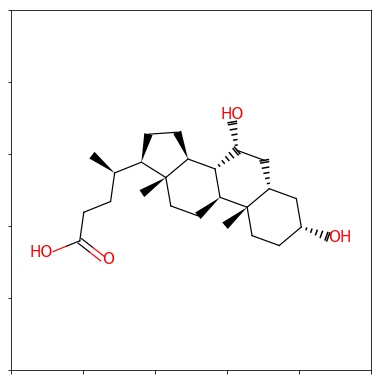

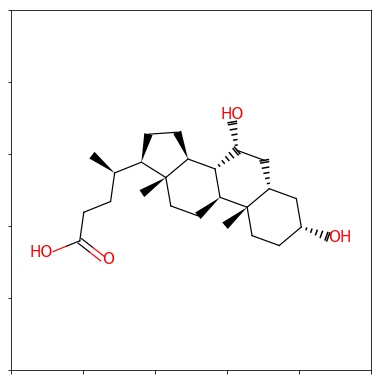

In [22]:
Draw.MolToMPL(testmol3, size=(200,200), kekulize=True, wedgeBonds=True, imageType=None, fitImage=True)